# 1. Configuration and Data Loading

This cell sets up the necessary libraries, defines the input file configuration (grouped by dimension), and includes the function to load and sample data using h5py.

In [9]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from typing import Dict, Any, List

# --- CẤU HÌNH ---
file_configs = {
    # Nhóm 512 chiều
    'clip-vit-base-patch32': {'filename': '.cache/clip-vit-base-patch32/image_embeddings/clip-vit-base-patch32_Images_Embedded_1_to_100000.h5', 'dim': 512, 'group': '512D'},
    'clip-vit-base-patch16': {'filename': '.cache/clip-vit-base-patch16/image_embeddings/clip-vit-base-patch16_Images_Embedded_1_to_100000.h5', 'dim': 512, 'group': '512D'},
    # Nhóm 768 chiều
    'clip-vit-large-patch14': {'filename': '.cache/clip-vit-large-patch14/image_embeddings/clip-vit-large-patch14_Images_Embedded_1_to_100000.h5', 'dim': 768, 'group': '768D'},
    'clip-vit-large-patch14-336': {'filename': '.cache/clip-vit-large-patch14-336/image_embeddings/clip-vit-large-patch14-336_Images_Embedded_1_to_10000.h5', 'dim': 768, 'group': '768D'},
}

EMBEDDING_KEY = 'embeddings' # Tên trường chứa vector nhúng trong tệp H5
SAMPLE_SIZE = 10000 
NUM_CLUSTERS_KMEANS = 4 # Số cụm giả định để đánh giá phân biệt

def load_and_sample_embeddings(filename: str, model_name: str, expected_dim: int, sample_size: int) -> np.ndarray | None:
    """Tải và lấy K phần tử đầu tiên (first K sampling) của các embeddings từ tệp H5."""
    try:
        # --- LOGIC TẢI TỪ H5PY ---
        with h5py.File(filename, 'r') as f:
            if EMBEDDING_KEY not in f:
                 raise KeyError(f"Field '{EMBEDDING_KEY}' does not exist in the file.")
            embeddings = f[EMBEDDING_KEY][:]
        # ------------------------------------
        
        current_count = embeddings.shape[0]

        if embeddings.shape[1] != expected_dim:
            print(f"Size error: {model_name} has dimension {embeddings.shape[1]}, which does not match {expected_dim}. Skipping.")
            return None

        # --- ĐIỀU CHỈNH: LẤY MẪU ĐẦU TIÊN (FIRST K) ---
        if current_count >= sample_size:
            print(f"[{model_name}]: Taking the first {sample_size} points.")
            embeddings = embeddings[:sample_size]
        elif current_count < sample_size:
             # Nếu số lượng ít hơn SAMPLE_SIZE, lấy tất cả
             print(f"[{model_name}]: Taking all {current_count} points (less than {sample_size}).")
        # ---------------------------------------------

        # Normalization (Crucial if your vectors are not already unit length, e.g., for Cosine Similarity)
        norm_check = np.linalg.norm(embeddings, axis=1)
        if not np.allclose(norm_check, 1.0, atol=1e-3):
             embeddings = embeddings / norm_check[:, np.newaxis]

        return embeddings
    except FileNotFoundError:
        print(f"ERROR: File {filename} not found. Please check the file name.")
        return None
    except KeyError as e:
        print(f"ERROR: {e} in file {filename}.")
        return None
    except Exception as e:
         print(f"OTHER ERROR loading {filename}: {e}")
         return None

# --- LOAD AND GROUP DATA ---
data_by_group: Dict[str, List[pd.DataFrame]] = {'512D': [], '768D': []}
model_embeddings: Dict[str, np.ndarray] = {}
stats: Dict[str, Dict[str, Any]] = {}

for model_name, config in file_configs.items():
    embeddings = load_and_sample_embeddings(
        config['filename'],
        model_name,
        config['dim'],
        SAMPLE_SIZE
    )
    if embeddings is not None:
        model_embeddings[model_name] = embeddings
        
        data_by_group[config['group']].append(
            pd.DataFrame({
                'embedding': list(embeddings),
                'model': model_name
            })
        )

        stats[model_name] = {
            'Count': embeddings.shape[0],
            'Embedding_Dim': embeddings.shape[1],
            'Mean_Norm': np.mean(np.linalg.norm(embeddings, axis=1)), # Average vector magnitude
            'Mean': np.mean(embeddings),
            'StdDev': np.std(embeddings),
        }

[clip-vit-base-patch32]: Taking the first 10000 points.
[clip-vit-base-patch16]: Taking the first 10000 points.
[clip-vit-large-patch14]: Taking the first 10000 points.
[clip-vit-large-patch14-336]: Taking the first 10000 points.


# 2. Statistical and Geometric (PCA) Comparison

This cell displays the basic statistical table and plots the PCA for each dimension group (512D and 768D).


-------------------------------------------
BASIC STATISTICAL COMPARISON TABLE OF EMBEDDINGS
-------------------------------------------
                              Count  Embedding_Dim  Mean_Norm      Mean  \
clip-vit-base-patch32       10000.0          512.0        1.0 -0.000725   
clip-vit-base-patch16       10000.0          512.0        1.0  0.001249   
clip-vit-large-patch14      10000.0          768.0        1.0  0.000075   
clip-vit-large-patch14-336  10000.0          768.0        1.0  0.000384   

                              StdDev  
clip-vit-base-patch32       0.044188  
clip-vit-base-patch16       0.044177  
clip-vit-large-patch14      0.036084  
clip-vit-large-patch14-336  0.036082  
-------------------------------------------

⚡️ Geometric Evaluation using PCA (by dimension group)...


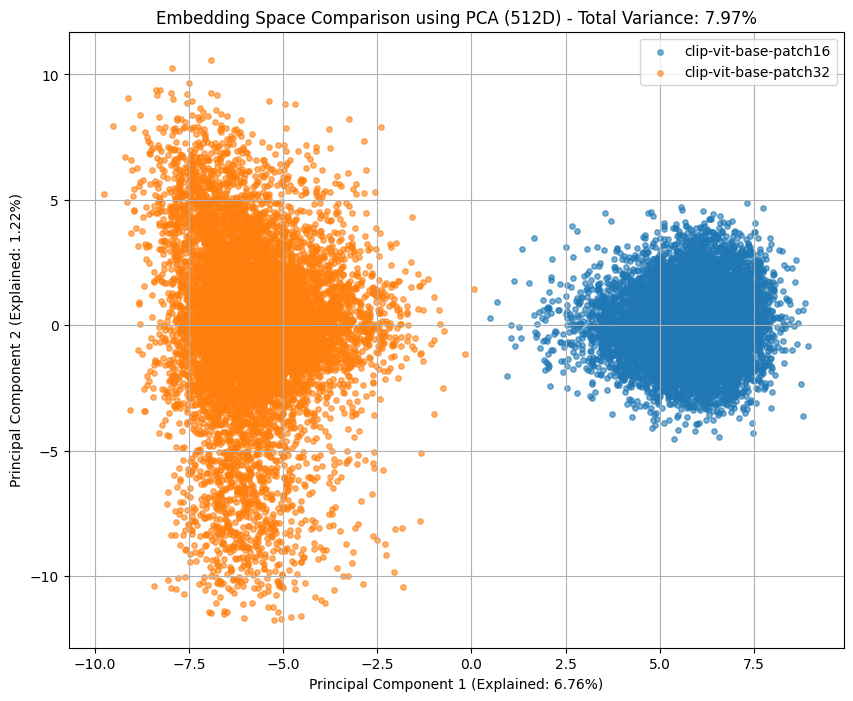

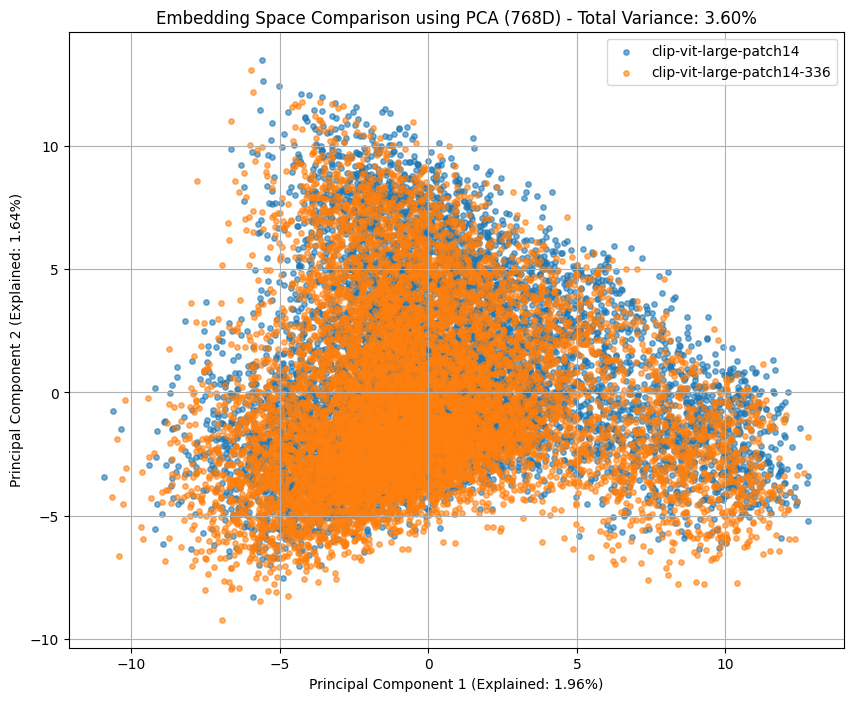

In [10]:
# --- A. STATISTICAL COMPARISON ---
print("\n-------------------------------------------")
print("BASIC STATISTICAL COMPARISON TABLE OF EMBEDDINGS")
print("-------------------------------------------")
stats_df = pd.DataFrame(stats).T
print(stats_df)
print("-------------------------------------------\n")

# --- B. GEOMETRIC COMPARISON (PCA) ---
print("⚡️ Geometric Evaluation using PCA (by dimension group)...")
for group_name, data_list in data_by_group.items():
    if not data_list:
        continue

    combined_df = pd.concat(data_list, ignore_index=True)
    X = np.array(combined_df['embedding'].tolist())

    # Data normalization 
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Perform PCA
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(X_scaled)

    pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
    pca_df['model'] = combined_df['model']
    
    # Visualization (using plt.show() to display directly)
    plt.figure(figsize=(10, 8))
    for name, group in pca_df.groupby('model'):
        plt.scatter(group['PC1'], group['PC2'], label=name, alpha=0.6, s=15)

    total_variance = pca.explained_variance_ratio_.sum() * 100
    plt.title(f'Embedding Space Comparison using PCA ({group_name}) - Total Variance: {total_variance:.2f}%')
    plt.xlabel(f'Principal Component 1 (Explained: {pca.explained_variance_ratio_[0]*100:.2f}%)')
    plt.ylabel(f'Principal Component 2 (Explained: {pca.explained_variance_ratio_[1]*100:.2f}%)')
    plt.legend()
    plt.grid(True)
    plt.show() # DISPLAY PLOT DIRECTLY

# 3. Embedding Quality Evaluation (Clustering Proxy)

This cell uses Clustering metrics (Silhouette Score and Inertia) as a proxy to assess the internal structure and quality of the embedding spaces.

In [11]:
# --- C. PERFORMANCE EVALUATION (CLUSTERING PROXY) ---

def evaluate_embedding_quality(embeddings: np.ndarray, num_clusters: int) -> Dict[str, Any]:
    """
    Uses K-Means Clustering and Silhouette Score as a proxy to evaluate embedding quality.
    """
    if len(embeddings) < num_clusters or num_clusters < 2:
        return {'Inertia': np.nan, 'Silhouette_Score': np.nan}
    
    try:
        # Random sampling for K-Means to speed up computation
        n_samples_for_kmeans = min(2000, embeddings.shape[0])
        idx = np.random.choice(embeddings.shape[0], n_samples_for_kmeans, replace=False)
        embeddings_sample = embeddings[idx]

        # 1. Perform K-Means
        kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
        labels = kmeans.fit_predict(embeddings_sample)
        
        # 2. Calculate Inertia (Cluster Tightness - lower is better)
        inertia = kmeans.inertia_
        
        # 3. Calculate Silhouette Score (Discriminability - closer to 1 is better)
        if len(np.unique(labels)) > 1:
            silhouette = silhouette_score(embeddings_sample, labels)
        else:
            silhouette = 0.0
            
        return {'Inertia': inertia, 'Silhouette_Score': silhouette}
        
    except Exception as e:
        return {'Inertia': np.nan, 'Silhouette_Score': np.nan}


print("\n🎯 Embedding Quality Evaluation (Clustering Proxy)...")

performance_results = {}
for model_name, embeddings in model_embeddings.items():
    results = evaluate_embedding_quality(embeddings, NUM_CLUSTERS_KMEANS)
    performance_results[model_name] = results

# Print performance evaluation results
print("\n-------------------------------------------")
print(f"CLUSTERING EVALUATION RESULTS (ASSUMING K={NUM_CLUSTERS_KMEANS})")
print("-------------------------------------------")

perf_df = pd.DataFrame(performance_results).T
print(perf_df)

print("\n--- Meaning of Metrics ---")
print("* **Inertia (Cluster Tightness):** Sum of squared distances to the nearest cluster center. Lower is better.")
print("* **Silhouette Score (Discriminability):** Measures similarity to its own cluster compared to other clusters. Closer to +1 is better.")
print("---------------------------\n")


🎯 Embedding Quality Evaluation (Clustering Proxy)...

-------------------------------------------
CLUSTERING EVALUATION RESULTS (ASSUMING K=4)
-------------------------------------------
                                Inertia  Silhouette_Score
clip-vit-base-patch32       1020.109558          0.029744
clip-vit-base-patch16        989.318787          0.029894
clip-vit-large-patch14      1005.041260          0.018318
clip-vit-large-patch14-336  1039.528198          0.022187

--- Meaning of Metrics ---
* **Inertia (Cluster Tightness):** Sum of squared distances to the nearest cluster center. Lower is better.
* **Silhouette Score (Discriminability):** Measures similarity to its own cluster compared to other clusters. Closer to +1 is better.
---------------------------

